# Import Libraries

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

import torchvision

from torchvision import transforms,datasets

from torchvision.utils import make_grid

# CUDA check

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

# Step 1. Download, extract and load CIFAR10 image dataset

In [4]:
batch_size = 32
num_workers = 2

In [5]:
MODEL_STORE_PATH = r"C:\Users\User\Desktop\DSA\Week_11_Python_Day_1\casestudy\data_cifar"

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# Download and load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Step 2. Show random batches of images in a grid

In [9]:
def show_random_batch(loader,ncols=8):

    # Fetch a batch of images from the training loader
    images, labels = next(iter(loader))

    images = (images+1)/2

    fig, axis = plt.subplots(figsize=(10, 10))

    axis.axis('off')

    axis.imshow(make_grid(images, nrow=ncols, normalize=True).permute(1, 2, 0))

    axis.set_title('Random Batch of Images from CIFAR-10')
    
    plt.show()

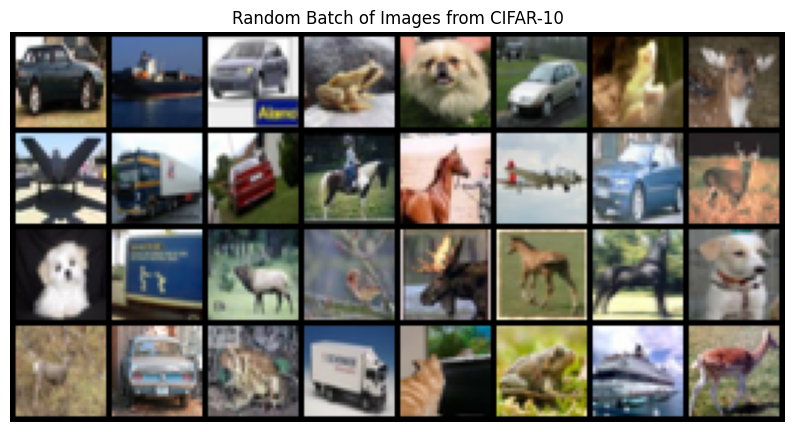

In [10]:
show_random_batch(train_loader)

# Step 3. Create a convolutional neural network

In [11]:
class CNN(nn.Module):
    
    def __init__(self,num_classes):

        super(CNN,self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 8x8 due to two max pooling operations with kernel size 2
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First convolutional layer followed by ReLU activation and max pooling
        x = self.pool(nn.functional.relu(self.conv1(x)))
        
        # Second convolutional layer followed by ReLU activation and max pooling
        x = self.pool(nn.functional.relu(self.conv2(x)))
        
        # Flatten the output from the convolutional layers
        x = x.view(-1, 64 * 8 * 8)
        
        # Fully connected layers with ReLU activation
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [12]:
num_classes = 10
learning_rate = 0.001

In [13]:
model = CNN(num_classes).to(device)

In [14]:
criterion = nn.CrossEntropyLoss() # loss function

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) # optimizer

# Step 4. Train a convolutional neural network and visualize the losses and errors

In [16]:
num_epochs = 10

In [17]:
train_losses,train_accuracies = [],[]

for epoch in range(num_epochs):

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Compute epoch statistics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch [1/10], Loss: 1.2853, Accuracy: 0.5385
Epoch [2/10], Loss: 0.9207, Accuracy: 0.6752
Epoch [3/10], Loss: 0.7558, Accuracy: 0.7343
Epoch [4/10], Loss: 0.6289, Accuracy: 0.7790
Epoch [5/10], Loss: 0.5152, Accuracy: 0.8187
Epoch [6/10], Loss: 0.4176, Accuracy: 0.8516
Epoch [7/10], Loss: 0.3290, Accuracy: 0.8825
Epoch [8/10], Loss: 0.2569, Accuracy: 0.9099
Epoch [9/10], Loss: 0.1980, Accuracy: 0.9297
Epoch [10/10], Loss: 0.1606, Accuracy: 0.9428


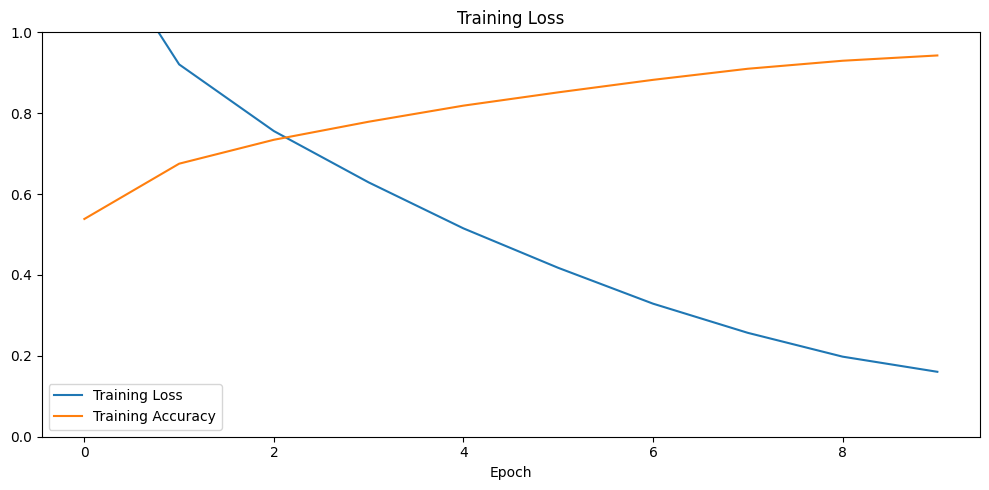

In [18]:
# Visualize the training loss and accuracy
plt.figure(figsize=(10, 5))

plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')

plt.ylim((0,1))
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Step 5. Model Testing

In [20]:
with torch.no_grad():
    
    correct,total = 0,0
    
    for images, labels in test_loader:
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
    
    print(f'Test Accuracy of the model on the {total} test images: {(correct/total)*100}.')

Test Accuracy of the model on the 10000 test images: 70.48.


# Step 6. Generate predictions on single images from the test set

In [21]:
class_labels = train_dataset.classes

In [22]:
batch_images, batch_labels = next(iter(test_loader))

In [23]:
with torch.no_grad():
    batch_outputs = model(batch_images)
    _, batch_predicted_classes = torch.max(batch_outputs, 1)
    batch_predicted_labels = [class_labels[class_idx.item()] for class_idx in batch_predicted_classes]

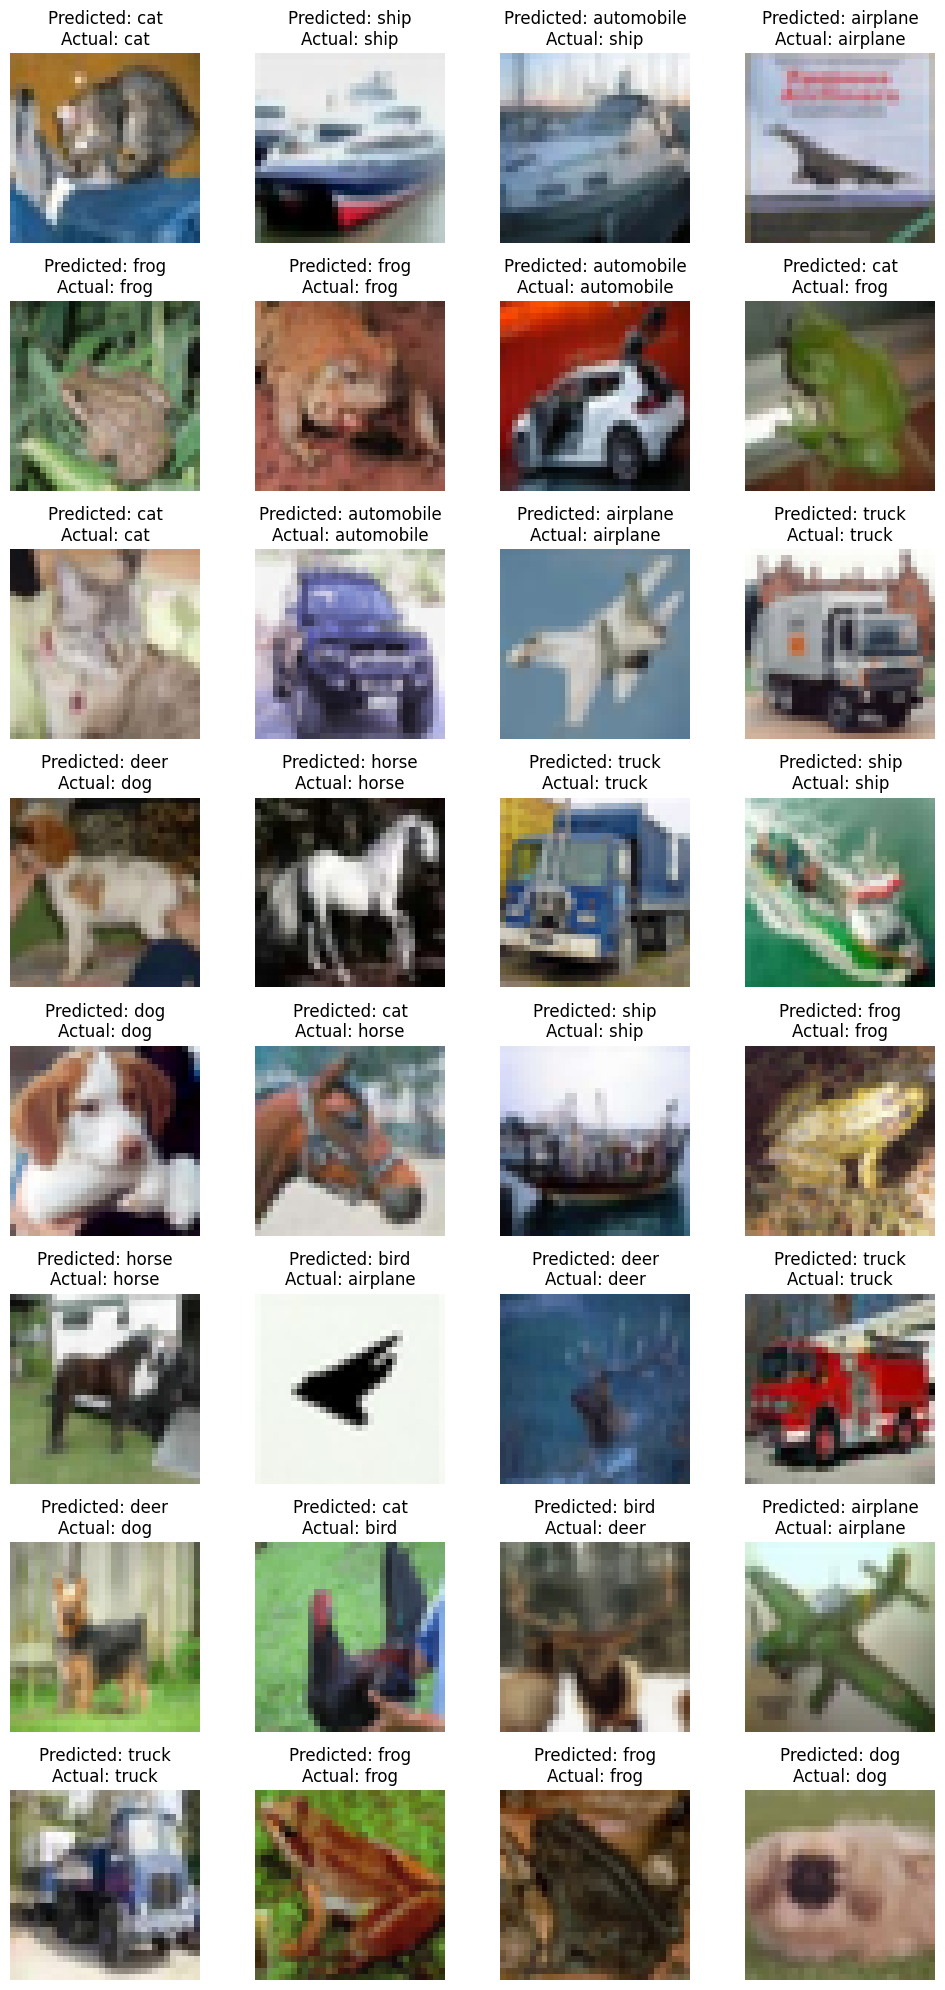

In [25]:
batch_images = (batch_images+1)/2

plt.figure(figsize=(10,20))

for idx in range(len(batch_images)):
    plt.subplot(8, 4, idx + 1)
    plt.imshow(np.transpose(batch_images[idx].numpy(), (1, 2, 0)))
    plt.title(f'Predicted: {batch_predicted_labels[idx]}\nActual: {class_labels[batch_labels[idx].item()]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Step 7. Save and load model for further purposes

In [26]:
# Save the model checkpoint
torch.save(model.state_dict(), MODEL_STORE_PATH + '\cnn_model.pth')

In [27]:
# Instantiate the model again
model = CNN(num_classes=10)

In [28]:
# Load the model checkpoint
model.load_state_dict(torch.load(MODEL_STORE_PATH + '\cnn_model.pth'))

<All keys matched successfully>

In [29]:
# Set the model to evaluation mode
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)